# Scraping Notícias

In [ ]:
# Importar bibliotecas
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='acritica(Manaus)')

In [ ]:
# Scraping das notícias
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

linkMateria = []
tituloMateria = []
subTituloMateria = []
corpoMateria = [] 

for url in urls.url:
  try:

    req = requests.get(url)
    soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")
    
    if soup.find('h1',class_="styled__HeadingOne-sc-fdx3oi-0 kHuocA"):
      link = url
      titulo = soup.find('h1',class_="styled__HeadingOne-sc-fdx3oi-0 kHuocA").text
      subTitulo = soup.find('p',class_="styled__Paragraph-sc-fdx3oi-6 haioyU").text 

      for div in soup.select('[class="Block__Component-sc-1uj1scg-0 gBnjEf"]'):
        p = div.find_all('p')
      corpoMateria.append(p)

    else:
      link = url
      titulo = soup.find('h1',class_="styled__HeadingOne-sc-fdx3oi-0 jQPYxy").text
      subTitulo = soup.find('p',class_="styled__Paragraph-sc-fdx3oi-6 ccmVtC").text 

      for div in soup.select('[class="Block__Component-sc-1uj1scg-0 bVxWXz"]'):
        p = div.find_all('p')
      corpoMateria.append(p)

    linkMateria.append(link)
    tituloMateria.append(titulo)
    subTituloMateria.append(subTitulo)

  except:
    pass

In [ ]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria,subTituloMateria, corpoMateria)), columns=['link','titulo','subtitulo', 'materia'])
df.head(3)

In [ ]:
# Salvar o conteúdo em excel
df.to_excel('acritica.xlsx')

# Mineração de texto

In [11]:
# Importar bibliotecas
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [5]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Ler base
df = pd.read_excel('/content/acritica.xlsx')

# Remover duplicados
df = df.drop_duplicates(subset=['link'], keep='first')

In [7]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/manausStopwords.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [8]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [9]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transforma em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(mode = "RGBA", background_color=None,width=800, height=400, max_words=50).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [12]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = limparTitulos(df['titulo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [13]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [18]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(50) 

,Termos,Frequência
3,homem,11
38,suspeito,8
64,pauladas,7
30,morto,6
54,assalto,5
16,tentativa,4
55,espancado,4
40,preso,4
5,bairro,4
67,cometer,3


In [19]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(50)

,Termos,Frequência
0,homem,62
89,policia,50
9,zona,49
7,bairro,46
76,pessoas,31
34,crime,31
159,rua,27
762,local,26
14,delegacia,25
18,dehs,22


## Nuvem de palavras

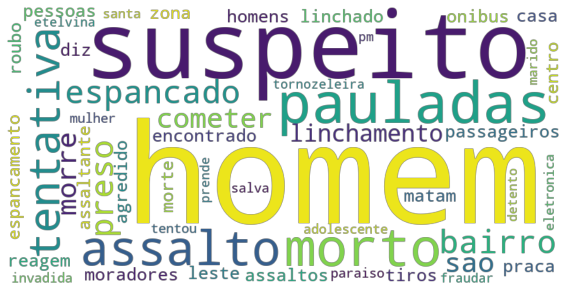

In [ ]:
gerarNuvem(frequenciaTitulo)

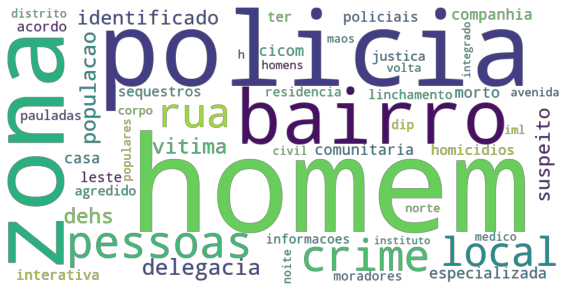

In [ ]:
gerarNuvem(frequenciaMateria)